# GAN for Face Generation

This notebook will train a GAN on the CelebA dataset for generating faces and then the generator will be used to demonstrate what is possible with such a trained model. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

This was completed as part of the Computer Vision course in the Advanced Machine Learning specialisation on Coursera.

This is the same structure as used in the notebook on deep generative models under Bayesian (as a follow on for the VAE), but includes methods to manipulate the generated faces, hence is included as well.

In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os
import zipfile
import warnings
warnings.filterwarnings("ignore")

from ops import *
from utils import *

In [2]:
DATA_PATH = 'img_align_celeba/'
Z_DIM = 100
BATCH_SIZE = 128
IMAGE_SIZE = 32 #reduced size to reduce training time

In [3]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

# Implementation of GAN

## Generator function

In [4]:
#create and compile DCGAN model
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LeakyReLU,\
      BatchNormalization, Conv2DTranspose, Conv2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from PIL import Image

def generator_model(latent_dim=100, leaky_alpha=0.2, init_stddev=0.02):

    g = Sequential()
    g.add(Dense(4*4*512, input_shape=(latent_dim,),
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(Reshape(target_shape=(4, 4, 512)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same',
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', 
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', 
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(Activation('tanh'))
    g.summary()
    return g

Using TensorFlow backend.


## Discriminator function

In [5]:
def discriminator_model(leaky_alpha=0.2, init_stddev=0.02):
    d = Sequential()
    d.add(Conv2D(64, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev),
               input_shape=(32, 32, 3)))
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Conv2D(128, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(BatchNormalization())
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Conv2D(256, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(BatchNormalization())
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Flatten())
    d.add(Dense(1, kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(Activation('sigmoid'))
    d.summary()
    return d

## Define the GAN

In [6]:
def DCGAN(sample_size=100):
    #generator
    g = generator_model(sample_size, 0.2, 0.02)

    #discriminator
    d = discriminator_model(0.2, 0.02)
    d.compile(optimizer=Adam(lr=0.001, beta_1=0.5), loss='binary_crossentropy')
    d.trainable = False
    
    #GAN
    gan = Sequential([g, d])
    gan.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss='binary_crossentropy')
    
    return gan, g, d

## Load the data

In [7]:
#image processing and plotting functions

def load_image(filename, size=(32, 32)):
    img = plt.imread(filename)
    #crop
    rows, cols = img.shape[:2]
    crop_r, crop_c = 150, 150
    start_row, start_col = (rows - crop_r) // 2, (cols - crop_c) // 2
    end_row, end_col = rows - start_row, cols - start_row
    img = img[start_row:end_row, start_col:end_col, :]
    #resize
    img = np.array(Image.fromarray(img).resize(size))
    return img

def preprocess(x):
    return (x/255)*2-1

def deprocess(x):
    return np.uint8((x+1)/2*255)

def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])  

def show_losses(losses):
    losses = np.array(losses)  
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

def show_images(generated_images):
    n_images = len(generated_images)
    cols = 5
    rows = n_images//cols
    plt.figure(figsize=(8, 6))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [8]:
#extract data downloaded from https://www.kaggle.com/jessicali9530/celeba-dataset (jpeg form)
zip_ref = zipfile.ZipFile('celeba-dataset.zip','r')
zip_ref.extractall()
zip_ref.close()


#load attributes
import pandas as pd
attr = pd.read_csv('list_attr_celeba.csv')
attr = attr.set_index('image_id')

import numpy as np
from sklearn.model_selection import train_test_split

IMG_NAME_LENGTH = 6
file_path = "img_align_celeba/"
img_id = np.arange(1,len(attr.index)+1)
img_path = []
for i in range(len(img_id)):
    img_path.append(file_path + (IMG_NAME_LENGTH - len(str(img_id[i])))*'0' + str(img_id[i]) + '.jpg')
    
#80:20 train:test split
train_path = img_path[:int((0.8)*len(img_path))]
val_path = img_path[int((0.8)*len(img_path)):]

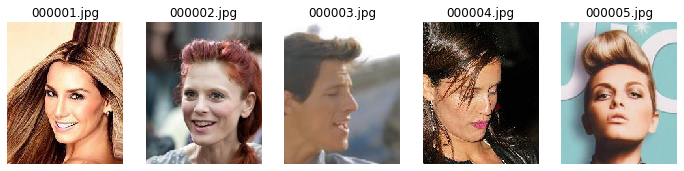

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [9]:
#sanity check
from skimage.io import imread

def get_input(path):
    """get specific image from path"""
    img = imread(path)
    return img

fig, ax = plt.subplots(1, 5, figsize=(12, 20))
for i in range(5):    
    ax[i].imshow(get_input(img_path[i]))
    ax[i].axis('off')
    ax[i].set_title(img_path[i][-10:])
plt.show()
    
attr.iloc[:5]

## Training the GAN 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 256)        


Epoch:   1/25 Discriminator Loss: 1.0558 Generator Loss: 2.3368
--------------- Epoch 2 ---------------



Epoch:   2/25 Discriminator Loss: 0.9420 Generator Loss: 2.0723
--------------- Epoch 3 ---------------



Epoch:   3/25 Discriminator Loss: 1.2862 Generator Loss: 0.8282
--------------- Epoch 4 ---------------



Epoch:   4/25 Discriminator Loss: 1.1111 Generator Loss: 2.1291
--------------- Epoch 5 ---------------



Epoch:   5/25 Discriminator Loss: 1.2898 Generator Loss: 0.6498
--------------- Epoch 6 ---------------



Epoch:   6/25 Discriminator Loss: 1.9267 Generator Loss: 0.5365
--------------- Epoch 7 ---------------



Epoch:   7/25 Discriminator Loss: 1.2252 Generator Loss: 1.0294
--------------- Epoch 8 ---------------



Epoch:   8/25 Discriminator Loss: 1.7989 Generator Loss: 0.6692
--------------- Epoch 9 ---------------



Epoch:   9/25 Discriminator Loss: 1.1915 Generator Loss: 1.4929
--------------- Epoch 10 ---------------



Epoch:  10/25 Discriminator Loss: 0.8979 Generator Loss: 2.1825
--------------- Epoch 11 ---------------



Epoch:  11/25 Discriminator Loss: 0.8383 Generator Loss: 2.3922
--------------- Epoch 12 ---------------



Epoch:  12/25 Discriminator Loss: 0.7883 Generator Loss: 2.0176
--------------- Epoch 13 ---------------



Epoch:  13/25 Discriminator Loss: 1.1361 Generator Loss: 2.0181
--------------- Epoch 14 ---------------



Epoch:  14/25 Discriminator Loss: 1.1784 Generator Loss: 1.0774
--------------- Epoch 15 ---------------



Epoch:  15/25 Discriminator Loss: 1.3022 Generator Loss: 1.5739
--------------- Epoch 16 ---------------



Epoch:  16/25 Discriminator Loss: 1.9609 Generator Loss: 1.5765
--------------- Epoch 17 ---------------



Epoch:  17/25 Discriminator Loss: 0.8062 Generator Loss: 2.8919
--------------- Epoch 18 ---------------



Epoch:  18/25 Discriminator Loss: 1.0926 Generator Loss: 1.7403
--------------- Epoch 19 ---------------



Epoch:  19/25 Discriminator Loss: 1.0203 Generator Loss: 1.7658
--------------- Epoch 20 ---------------



Epoch:  20/25 Discriminator Loss: 1.1881 Generator Loss: 1.6938
--------------- Epoch 21 ---------------



Epoch:  21/25 Discriminator Loss: 1.1931 Generator Loss: 1.6890
--------------- Epoch 22 ---------------



Epoch:  22/25 Discriminator Loss: 1.0405 Generator Loss: 1.7354
--------------- Epoch 23 ---------------



Epoch:  23/25 Discriminator Loss: 1.1437 Generator Loss: 2.6313
--------------- Epoch 24 ---------------



Epoch:  24/25 Discriminator Loss: 1.3264 Generator Loss: 2.3182
--------------- Epoch 25 ---------------



Epoch:  25/25 Discriminator Loss: 1.6143 Generator Loss: 2.5158


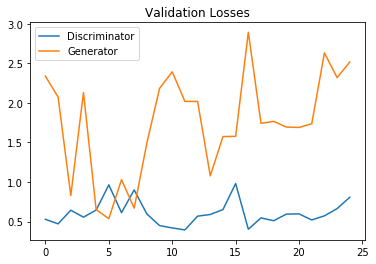

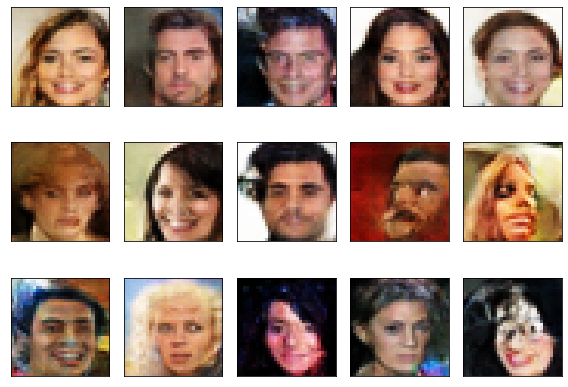

In [6]:
#function to train model
def train(sample_size=100, epochs=25, BATCH_SIZE=128, eval_size=16, smooth=0.1, Z_DIM=100):    
    batchCount=len(train_path)//BATCH_SIZE
    y_train_real, y_train_fake = make_labels(BATCH_SIZE)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)
    
    #create a GAN, generator and discriminator
    gan, g, d = DCGAN(sample_size)
    
    losses = []    
    
    for e in range(epochs):
        print('-'*15, 'Epoch %d' % (e+1), '-'*15)
        for i in tqdm_notebook(range(batchCount)):
            
            path_batch = train_path[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            image_batch = np.array([preprocess(load_image(filename)) for filename in path_batch])
            
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, Z_DIM))
            generated_images = g.predict_on_batch(noise)    #train discriminator on generated images
            d.trainable = True
            d.train_on_batch(image_batch, y_train_real*(1-smooth))
            d.train_on_batch(generated_images, y_train_fake) #train generator
            d.trainable = False
            g_loss=gan.train_on_batch(noise, y_train_real)
        
        #evaluate
        test_path = np.array(val_path)[np.random.choice(len(val_path), eval_size, replace=False)]
        x_eval_real = np.array([preprocess(load_image(filename)) for filename in test_path])        
        
        noise = np.random.normal(loc=0, scale=1, size=(eval_size, sample_size))
        x_eval_fake = g.predict_on_batch(noise)
        
        d_loss  = d.test_on_batch(x_eval_real, y_eval_real)
        d_loss += d.test_on_batch(x_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(noise, y_eval_real)
        
        losses.append((d_loss/2, g_loss))
  
        print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
            e+1, epochs, d_loss, g_loss))  
        
        #show_images(x_eval_fake[:10])
        
        #save model weights from epoch
        d.save_weights('model_weights/discriminator_{}.h5'.format(e))
        g.save_weights('model_weights/generator_{}.h5'.format(e))
        gan.save_weights('model_weights/gan_{}.h5'.format(e))
    
    #show result
    show_losses(losses)
    show_images(g.predict(np.random.normal(loc=0, scale=1, size=(15, sample_size))))    
    return gan, g, d

gan, g, d = train()

In [76]:
#load model weights
gan, g, d = DCGAN()

#d.load_model('discriminator_{}.h5')
g.load_weights('model_weights/generator_24.h5')
#gan.load_weights('gan_{}.h5')

Z_DIM=100
BATCH_SIZE=128

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 8192)              827392    
_________________________________________________________________
reshape_12 (Reshape)         (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_89 (Activation)   (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_57 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_90 (Activation)   (None, 8, 8, 256)       

In [77]:
samples = 10
counter = 0
samples_dir = 'samples'
for idx in range(samples):    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = g.predict(batch_z)
    for sample in samples:
        plt.imsave(os.path.join(samples_dir, 'sample_'+str(counter)+'.png'), (deprocess(sample)))
        counter += 1

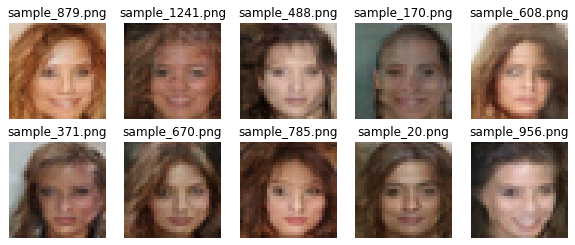

In [85]:
from os.path import join
def visualize(data_path, n_cols=5, n_rows=1):
    plt.figure(figsize = (2*n_cols,2*n_rows))
    for n, filename in enumerate(np.random.choice(os.listdir(data_path), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img = plt.imread(join(data_path, filename))
        plt.imshow(img)
        plt.title(filename)
    plt.show()
visualize(samples_dir, n_cols=5, n_rows=2)

## Face interpolation 

Let's interpolate between faces: below two vectors - $z_1$ and $z_2$ - are generated, and a batch of vectors returned of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Faces are then generated on them. The generator displays pictures in the range from -1 to 1. The faces generated all look like varying forms of the same general person.

In [98]:
from os.path import join

zs = np.random.uniform(-1, 1, [2, Z_DIM]).astype(np.float32)
alphas = np.linspace(0, 1, BATCH_SIZE)
batchz = np.zeros((BATCH_SIZE, Z_DIM))
for i, alpha in enumerate(alphas):
    batchz[i] = alpha*zs[0] + (1 - alpha)*zs[1]
samples = g.predict(batchz)
interpolation_dir = 'face_interpolation'
names = []
for i, sample in enumerate(samples):
    if i == 0:
        filename = 'z2.png'
        names.append(filename)
    elif i == len(samples) - 1:
        filename = 'z1.png'
        names.append(filename)
    else:
        filename = 'alpha_' + str(round(alphas[i], 3)) + '.png'
        if i&1 == 0 and i != len(samples) - 2:
            names.append(filename)
    plt.imsave(os.path.join(interpolation_dir, filename), (deprocess(sample)))

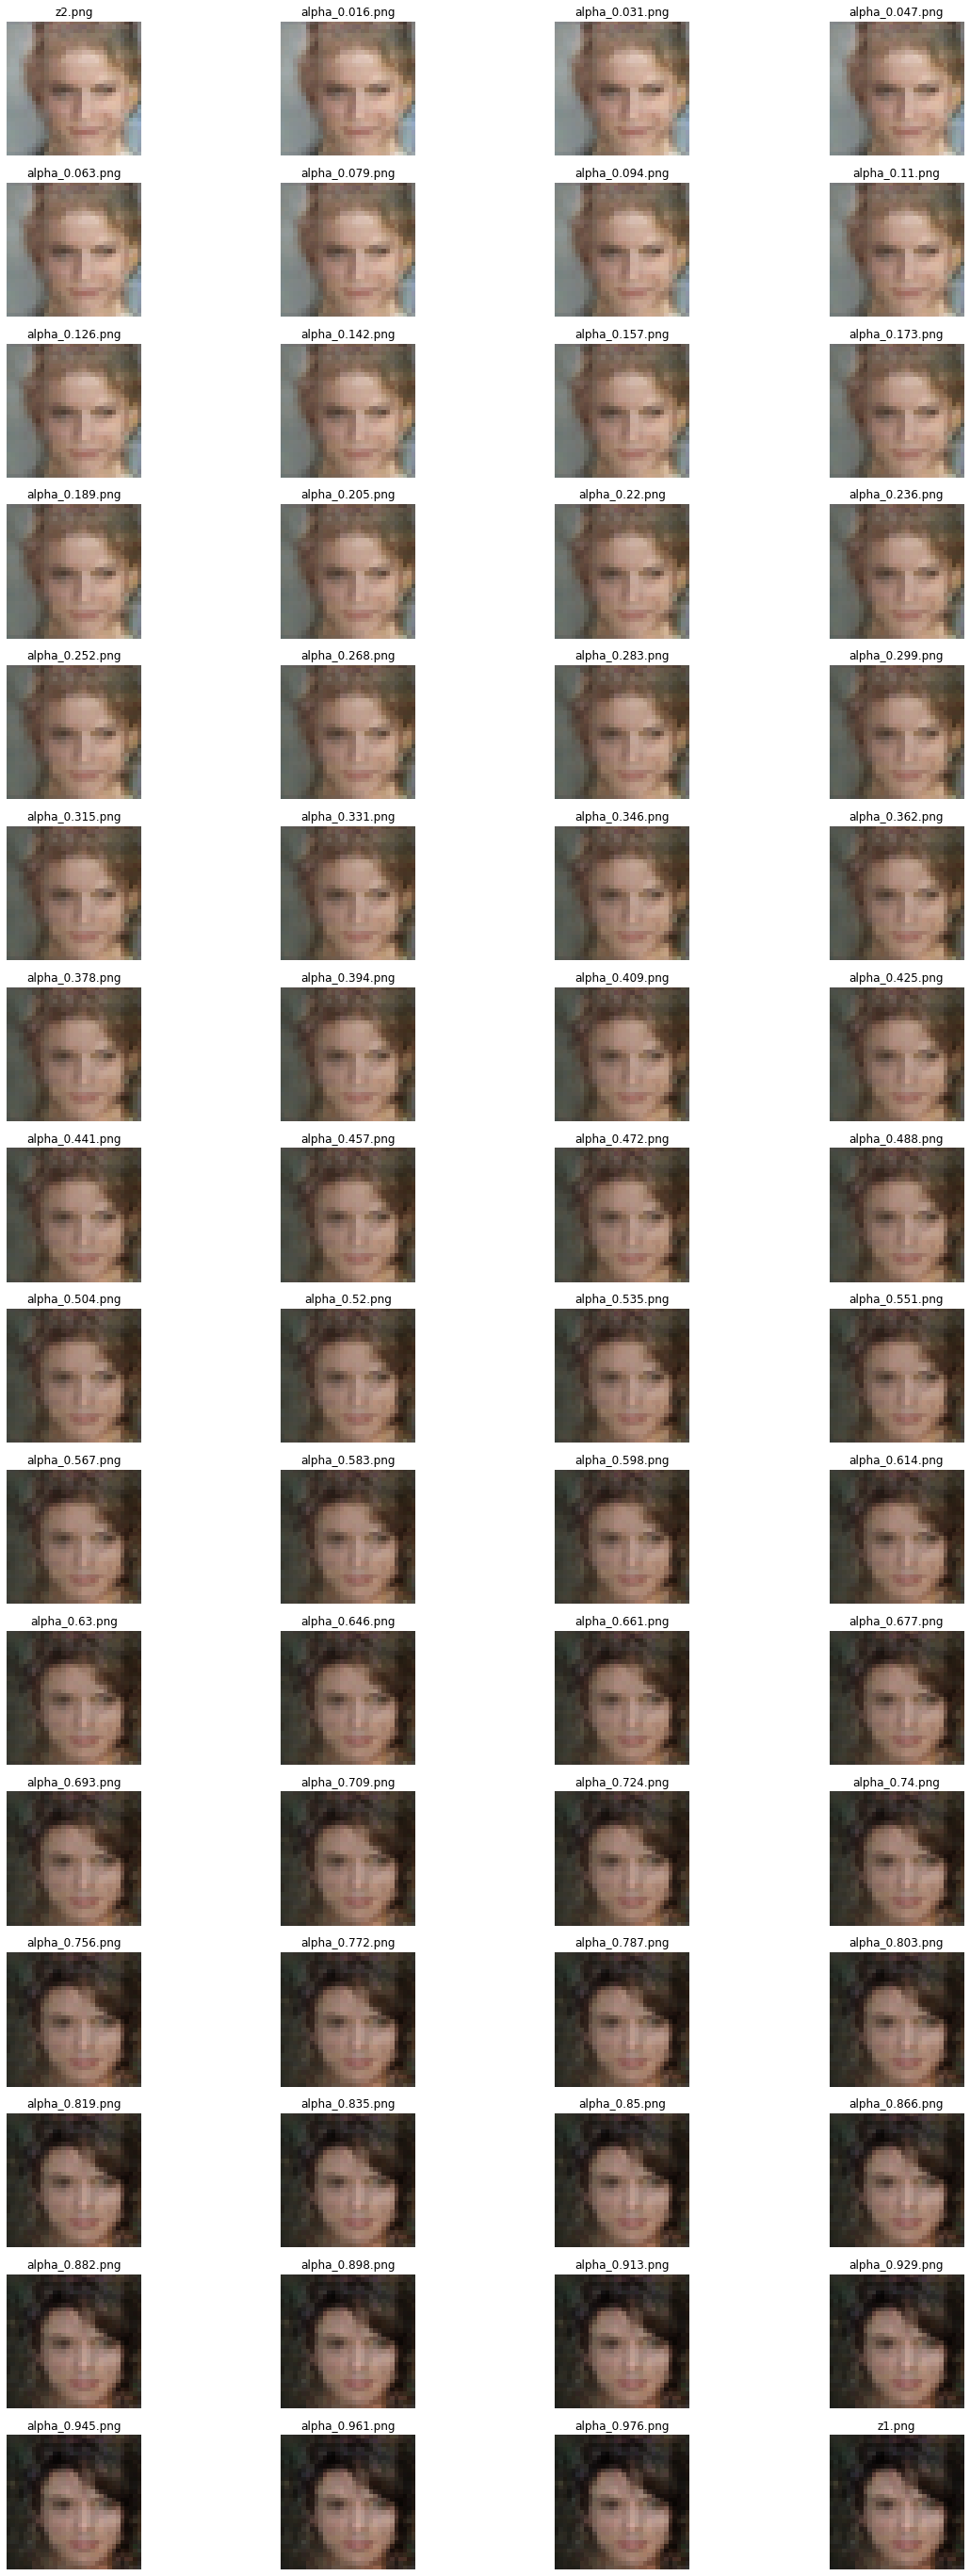

In [100]:
plt.figure(figsize=(20, 100))
for i, name in enumerate(names):
    plt.subplot(32, 4, i+1)
    plt.axis('off')
    img = plt.imread(join(interpolation_dir, name))
    plt.imshow(img)
    plt.title(name)
plt.show()

## Adding a smile

Let's make faces smile. Below several vectors z are found such that the generator generates smiling faces and non-smiling faces. The "smile vector" is calculated as the mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

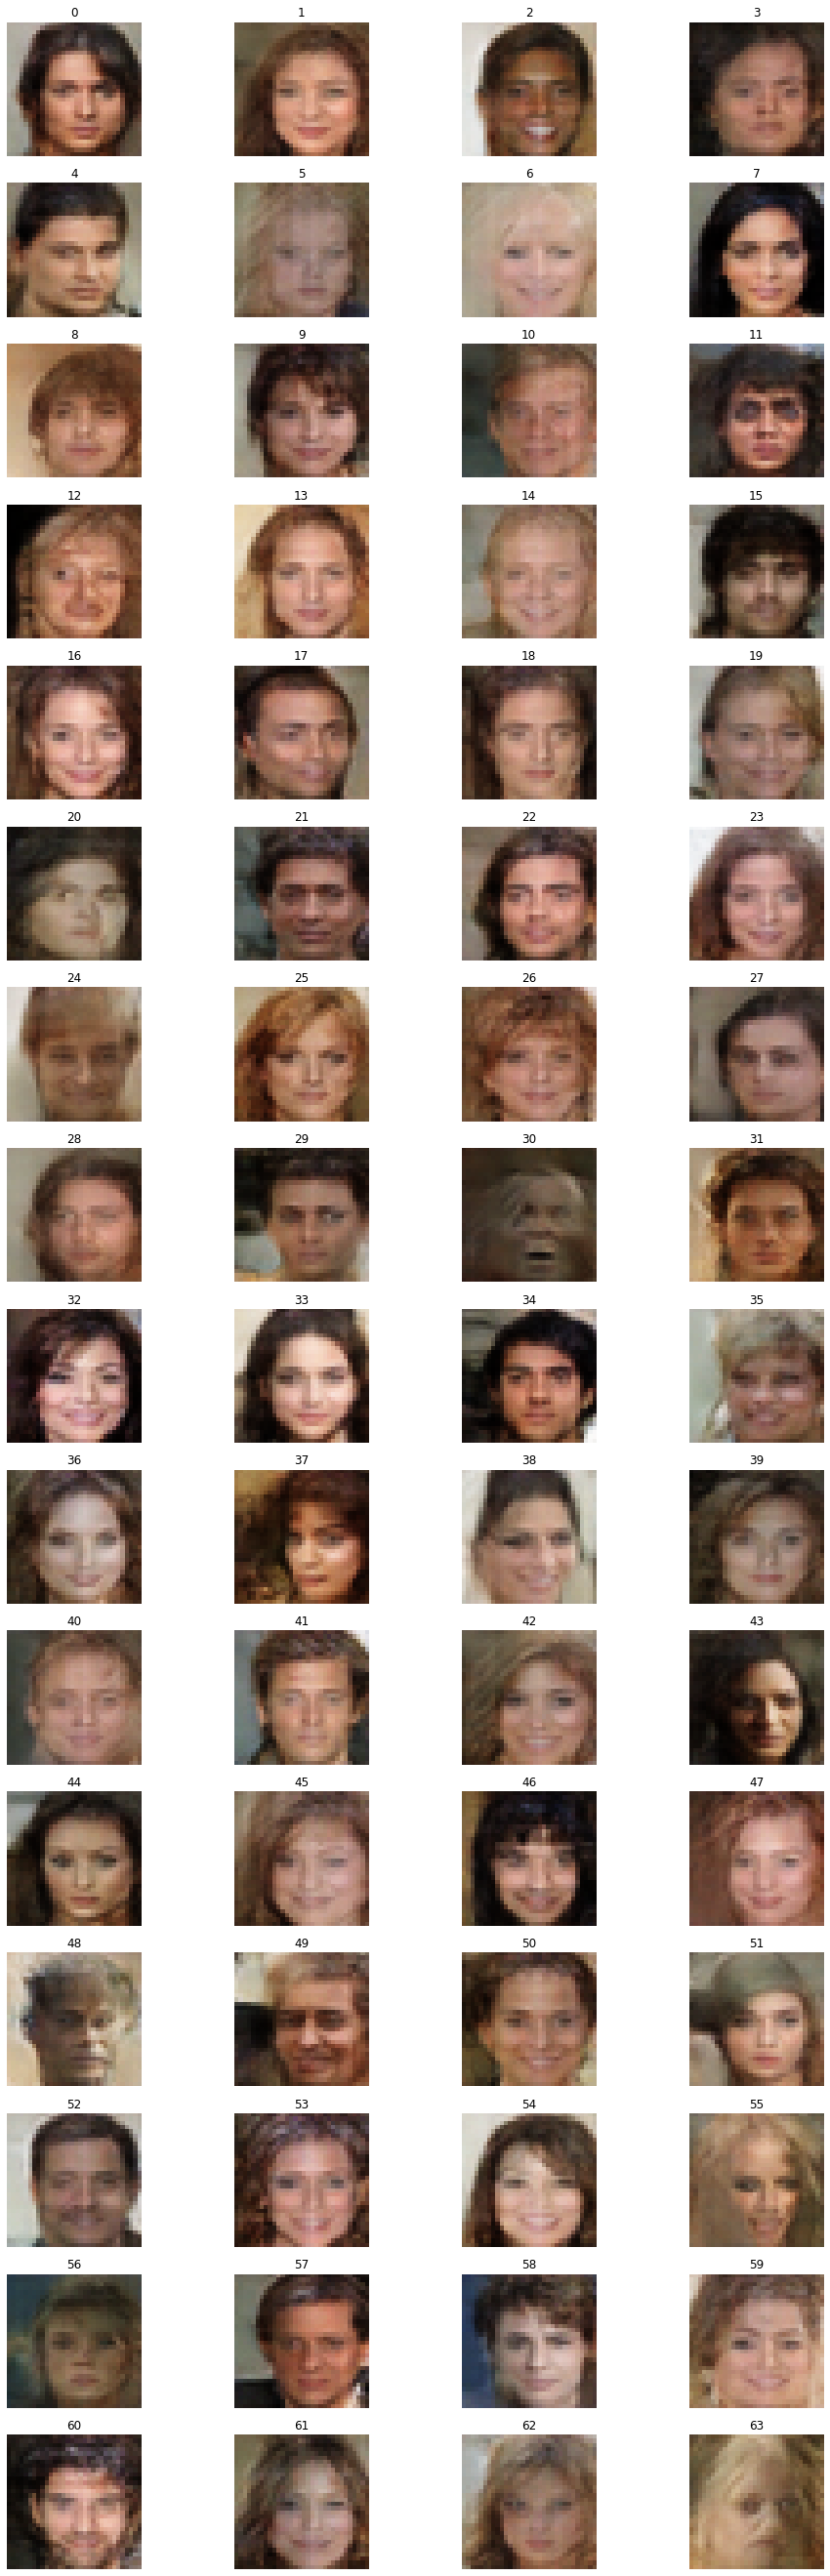

In [89]:
batchz = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
samples = g.predict(batchz)
samples = samples[:64]
plt.figure(figsize=(16, 48))
for i, sample in enumerate(samples):
    plt.subplot(16, 4, i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(deprocess(sample))
plt.show()

In [90]:
with_smiles = [61, 60, 59, 52, 53, 54, 55, 50, 49, 45, 46, 47, 42, 40, 36, 38, 35, 32, 25, 24, 23, 16, 19, 14, 9, 10, 6, 1, 2]
without_smiles = [63, 62, 58, 57, 56, 51, 48, 44, 43, 41, 39, 37, 34, 33, 31, 30, 29, 28, 27, 26, 22, 21, 20, 28, 17, 16, 15, 13, 12, 11, 8, 7, 5, 4, 3, 0]
with_smile_mean = batchz[with_smiles].mean(axis=0)
without_smile_mean = batchz[without_smiles].mean(axis=0)

smile_vector = with_smile_mean - without_smile_mean

add_smile = batchz + smile_vector
add_smile = add_smile.clip(-1, 1)
add_smile_samples = g.predict(add_smile)

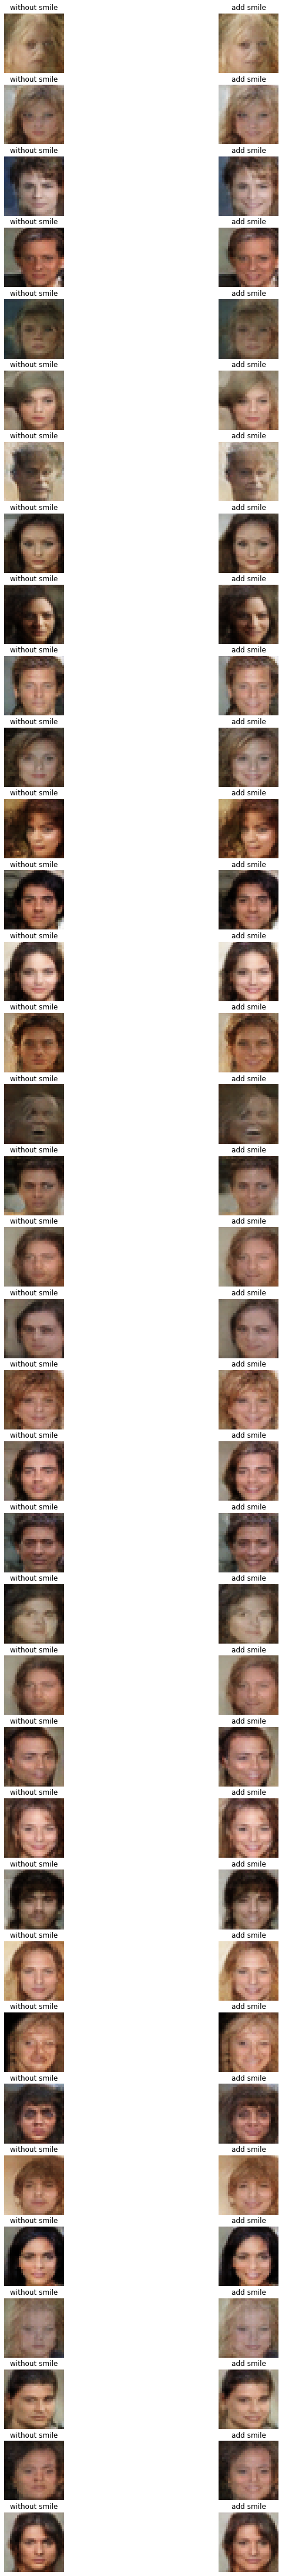

In [95]:
plt.figure(figsize = (12, 80))
for i, idx in enumerate(without_smiles):
    plt.subplot(len(without_smiles), 2, i*2+1)
    plt.axis('off')
    plt.title("without smile")
    plt.imshow(deprocess(samples[idx]))
    plt.subplot(len(without_smiles), 2, i*2+2)
    plt.axis('off')
    plt.title("add smile")
    plt.imshow(deprocess(add_smile_samples[idx]))
plt.show()